<a href="https://colab.research.google.com/github/ziadahmed562002-lgtm/Tech_C/blob/main/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/raw_house_data.csv')
df['HOA'] = df['HOA'].str.replace(',','')

df['HOA'] = df['HOA'].astype(float)

median_lot_acres = df['lot_acres'].median()
df['lot_acres'] = df['lot_acres'].fillna(median_lot_acres)

median_bathrooms = df['bathrooms'].median()
df['bathrooms'] = df['bathrooms'].fillna(median_bathrooms)

median_sqrt_ft = df['sqrt_ft'].median()
df['sqrt_ft'] = df['sqrt_ft'].fillna(median_sqrt_ft)

median_garage = df['garage'].median()
df['garage'] = df['garage'].fillna(median_garage)


df['kitchen_features'] = df['kitchen_features'].fillna('missing')


df['floor_covering'] = df['floor_covering'].fillna('missing')
# combine bedrooms + bathrooms into a single rooms feature
df["rooms"] = df["bedrooms"] + df["bathrooms"]



median_HOA = df['HOA'].median()
df['HOA'] = df['HOA'].fillna(median_HOA)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MLS               5000 non-null   int64  
 1   sold_price        5000 non-null   float64
 2   zipcode           5000 non-null   int64  
 3   longitude         5000 non-null   float64
 4   latitude          5000 non-null   float64
 5   lot_acres         5000 non-null   float64
 6   taxes             5000 non-null   float64
 7   year_built        5000 non-null   int64  
 8   bedrooms          5000 non-null   int64  
 9   bathrooms         5000 non-null   float64
 10  sqrt_ft           5000 non-null   float64
 11  garage            5000 non-null   float64
 12  kitchen_features  5000 non-null   object 
 13  fireplaces        5000 non-null   object 
 14  floor_covering    5000 non-null   object 
 15  HOA               5000 non-null   float64
 16  rooms             5000 non-null   float64


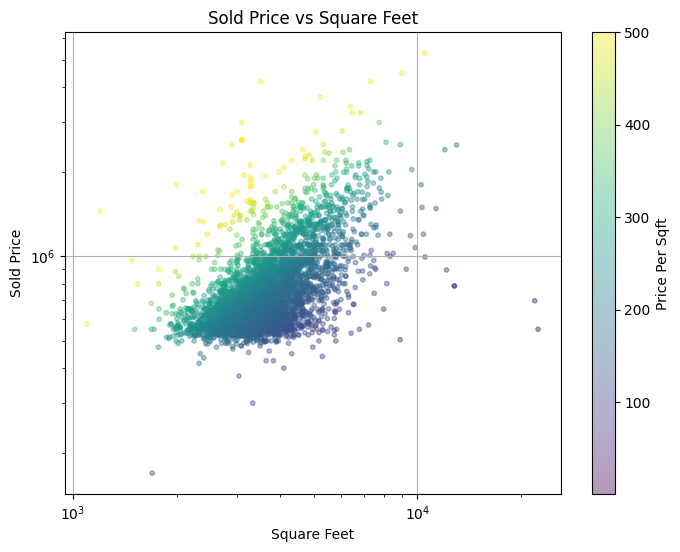

In [309]:
df["price_per_sqft"] = df["sold_price"] / df["sqrt_ft"]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["sqrt_ft"], df['sold_price'], c = df["price_per_sqft"], cmap = "viridis", alpha = .4,s=10, vmin = 0.7, vmax = 500)
plt.colorbar(scatter, label = 'Price Per Sqft')
plt.xlabel("Square Feet")
plt.ylabel("Sold Price")
plt.title("Sold Price vs Square Feet")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [310]:
def kmeans_custom(X, k, max_iters=100):
    # X is (n_samples, 2) for latitude and longitude
    n = X.shape[0]

    # randomly choose k initial centers
    idx = np.random.choice(n, k, replace=False)
    centers = X[idx]

    for _ in range(max_iters):
        # assign points to closest cluster
        dists = np.sqrt(((X[:, None, :] - centers[None, :, :])**2).sum(axis=2))
        labels = np.argmin(dists, axis=1)

        # recompute centers
        new_centers = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i]
            for i in range(k)
        ])

        # stop when centers converge
        if np.allclose(centers, new_centers, atol=1e-4):
            break

        centers = new_centers

    return labels, centers



In [311]:
coords = df[["latitude", "longitude"]].to_numpy()

labels, centers = kmeans_custom(coords, k=5)
labels[:10]


array([4, 4, 4, 4, 1, 1, 1, 1, 1, 1])

In [312]:
def cluster_inertia(X, labels, centers):
    return ((X - centers[labels])**2).sum()

results = {}

for k in range(5, 26):
    labels_k, centers_k = kmeans_custom(coords, k)
    inertia_k = cluster_inertia(coords, labels_k, centers_k)
    results[k] = inertia_k

best_k = min(results, key=results.get)
best_k


16

In [313]:
best_labels, best_centers = kmeans_custom(coords, best_k)

df["region"] = best_labels + 50   # region IDs from 50 upward


#Model 1

In [314]:
# PRICE TIER CLASSIFIER

def label_tier(ppsqft):
    if ppsqft < 180:
        return 0      # Affordable
    elif ppsqft < 260:
        return 1      # Mid-tier
    else:
        return 2      # Luxury

df["tier"] = df["price_per_sqft"].apply(label_tier)
print("Tier counts:\n", df["tier"].value_counts())


Tier counts:
 tier
1    2847
0    1471
2     682
Name: count, dtype: int64


In [315]:
# Classifier feature set
clf_features = [
    "latitude",
    "longitude",
    "sqrt_ft",
    "year_built",
    "region"
]

Xc = df[clf_features].to_numpy().astype(float)
yc = df["tier"].to_numpy().astype(int)

# Normalize
Xc_mean = Xc.mean(axis=0)
Xc_std  = Xc.std(axis=0)
Xc_norm = (Xc - Xc_mean) / Xc_std

# Train-test split
idx = np.random.permutation(len(Xc_norm))
split = int(0.8 * len(Xc_norm))

Xc_train = Xc_norm[idx[:split]]
yc_train = yc[idx[:split]]

Xc_test  = Xc_norm[idx[split:]]
yc_test  = yc[idx[split:]]

In [316]:
# KNN classifier
def knn_classifier_predict(X_train, y_train, x, k=7):
    dists = np.sqrt(np.sum((X_train - x)**2, axis=1))
    nn_ids = np.argpartition(dists, k)[:k]
    labels = y_train[nn_ids]
    vals, cnts = np.unique(labels, return_counts=True)
    return vals[np.argmax(cnts)]

# Evaluate
correct = 0
for i in range(len(Xc_test)):
    pred = knn_classifier_predict(Xc_train, yc_train, Xc_test[i], k=7)
    if pred == yc_test[i]:
        correct += 1

tier_accuracy = correct / len(Xc_test)
print("\nPrice Tier Classifier Accuracy:", tier_accuracy)


Price Tier Classifier Accuracy: 0.665


#Model 2

In [317]:
# Features for Model 2

best_features = [
    "rooms",
    "garage",
    "sqrt_ft",
    "lot_acres",
    "HOA",
    "year_built",
    "region"
]

X2 = df[best_features].to_numpy().astype(float)
y2 = df["price_per_sqft"].to_numpy().astype(float)

X2_mean = X2.mean(axis=0)
X2_std  = X2.std(axis=0)

X2_norm = (X2 - X2_mean) / X2_std

idx = np.random.permutation(len(X2_norm))
split = int(0.8 * len(X2_norm))

X2_train = X2_norm[idx[:split]]
y2_train = y2[idx[:split]]

X2_test  = X2_norm[idx[split:]]
y2_test  = y2[idx[split:]]



X2 = df[best_features].to_numpy().astype(float)
y2 = df["price_per_sqft"].to_numpy().astype(float)

# normalize features
X2_mean = X2.mean(axis=0)
X2_std = X2.std(axis=0)

X2_norm = (X2 - X2_mean) / X2_std

# shuffle
indices = np.arange(len(X2_norm))
np.random.shuffle(indices)

X2_norm = X2_norm[indices]
y2 = y2[indices]

# 80/20 split
split = int(0.8 * len(X2_norm))
X2_train = X2_norm[:split]
X2_test = X2_norm[split:]
y2_train = y2[:split]
y2_test = y2[split:]

print(X2_train.shape)
print(np.median(y2_train))


(4000, 7)
202.12063295764355


In [318]:
def linear_regression_train(X, y, lr=0.01, epochs=500):
    n, d = X.shape
    # Initialize weights
    w = np.zeros(d)
    b = 0.0

    for epoch in range(epochs):
        # Predictions
        y_pred = X.dot(w) + b

        # Errors
        error = y_pred - y

        # Gradients
        dw = (1/n) * X.T.dot(error)
        db = (1/n) * np.sum(error)

        # Update
        w -= lr * dw
        b -= lr * db

    return w, b


In [319]:
w_lin, b_lin = linear_regression_train(X2_train, y2_train, lr=0.01, epochs=800)
y_pred_lin = X2_test.dot(w_lin) + b_lin

# Metrics
mae_lin = np.mean(np.abs(y_pred_lin - y2_test))
rmse_lin = np.sqrt(np.mean((y_pred_lin - y2_test)**2))
mape_lin = np.mean(np.abs((y_pred_lin - y2_test) / y2_test)) * 100

print("Linear Regression MAE:", mae_lin)
print("Linear Regression RMSE:", rmse_lin)
print("Linear Regression MAPE:", mape_lin, "%")


Linear Regression MAE: 41.83840255508224
Linear Regression RMSE: 66.80392324392645
Linear Regression MAPE: 20.16279536447368 %


In [320]:

# KNN Regressor

def knn_regressor_predict(X_train, y_train, x, k=3):
    dists = np.sqrt(np.sum((X_train - x)**2, axis=1))
    nn_idx = np.argpartition(dists, k)[:k]
    return np.mean(y_train[nn_idx])

# Evaluations


preds = np.array([
    knn_regressor_predict(X2_train, y2_train, X2_test[i], k=3)
    for i in range(len(X2_test))
])

MAE  = np.mean(np.abs(preds - y2_test))
RMSE = np.sqrt(np.mean((preds - y2_test)**2))
MAPE = np.mean(np.abs((preds - y2_test) / y2_test)) * 100

SS_res = np.sum((y2_test - preds)**2)
SS_tot = np.sum((y2_test - np.mean(y2_test))**2)
R2 = 1 - (SS_res / SS_tot)

print("MAE:", MAE)
print("RMSE:", RMSE)
print("MAPE:", MAPE)
print("R2:", R2)



MAE: 35.30020430333823
RMSE: 60.69026113897086
MAPE: 17.1346508548698
R2: 0.2625235492508927


In [321]:
for k in [1, 3, 5, 7, 9, 11, 15]:
    preds = []
    for i in range(len(X2_test)):
        preds.append(knn_regressor_predict(X2_train, y2_train, X2_test[i], k=k))
    preds = np.array(preds)

    mae = np.mean(np.abs(preds - y2_test))
    rmse = np.sqrt(np.mean((preds - y2_test)**2))
    mape = np.mean(np.abs((preds - y2_test) / y2_test)) * 100

    print("K =", k, "| MAE:", mae, "| RMSE:", rmse, "| MAPE:", mape, "%")


K = 1 | MAE: 41.407919971155515 | RMSE: 69.73708199367951 | MAPE: 19.882938336363537 %
K = 3 | MAE: 35.30020430333823 | RMSE: 60.69026113897086 | MAPE: 17.1346508548698 %
K = 5 | MAE: 34.614938981438144 | RMSE: 58.084484786255985 | MAPE: 17.020312480549265 %
K = 7 | MAE: 34.203676584285496 | RMSE: 57.267396099510506 | MAPE: 16.693247164315885 %
K = 9 | MAE: 34.439131812663994 | RMSE: 57.78968155908493 | MAPE: 16.683862528841228 %
K = 11 | MAE: 34.446467253166546 | RMSE: 57.94705026949104 | MAPE: 16.691941537964983 %
K = 15 | MAE: 34.81455896416907 | RMSE: 58.80022218824012 | MAPE: 16.897366026991335 %


In [322]:
def predict_price_from_row(df_row):

    x = np.array([
        df_row["rooms"],
        df_row["garage"],
        df_row["sqrt_ft"],
        df_row["lot_acres"],
        df_row["HOA"],
        df_row["year_built"],
        df_row["region"]
    ], dtype=float)

    # normalize
    x_norm = (x - X2_mean) / X2_std

    # knn regression
    ppsqft = knn_regressor_predict(X2_train, y2_train, x_norm, k=3)

    # convert back to price
    final_price = ppsqft * df_row["sqrt_ft"]

    return ppsqft, final_price



In [323]:
sample = df.iloc[100]
price_sqft_pred, price_pred = predict_price_from_row(sample)

print("Predicted price per sqft:", price_sqft_pred)
print("Predicted sale price:", price_pred)
print("Actual sale price:", sample['sold_price'])



Predicted price per sqft: 302.6179292204501
Predicted sale price: 2044184.1118841404
Actual sale price: 2100000.0


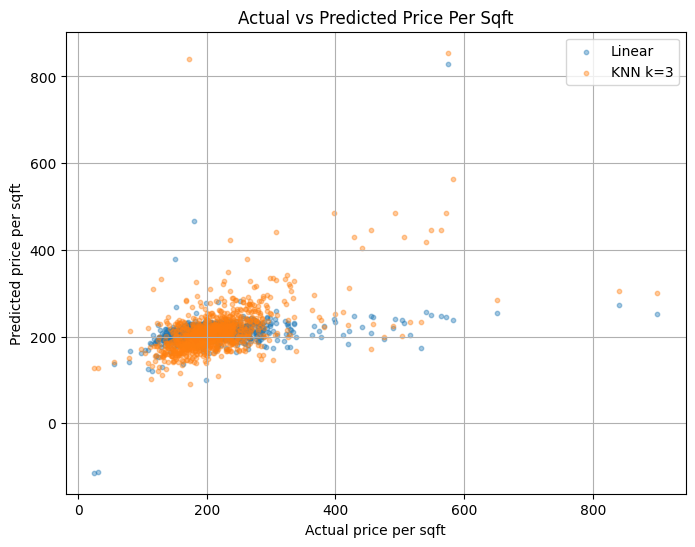

In [324]:
plt.figure(figsize=(8,6))
plt.scatter(y2_test, y_pred_lin, alpha=0.4, s=10, label="Linear")
plt.scatter(y2_test, np.array([knn_regressor_predict(X2_train, y2_train, X2_test[i], k=3)
                               for i in range(len(X2_test))]),
            alpha=0.4, s=10, label="KNN k=3")

plt.xlabel("Actual price per sqft")
plt.ylabel("Predicted price per sqft")
plt.title("Actual vs Predicted Price Per Sqft")
plt.legend()
plt.grid(True)
plt.show()


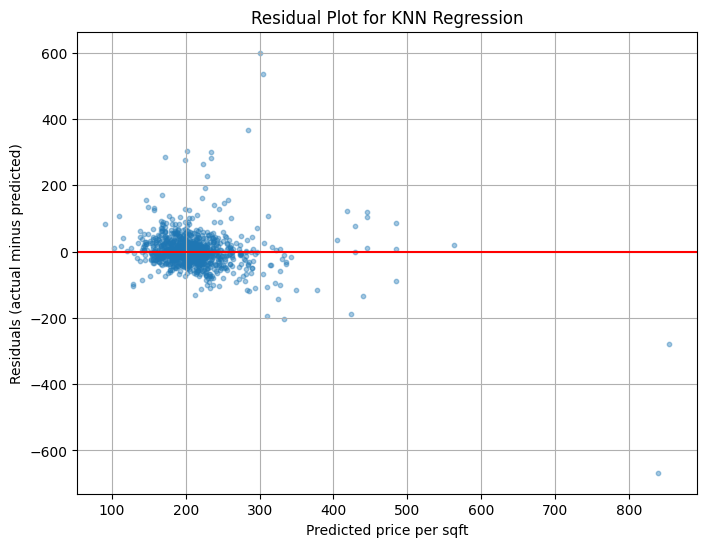

In [325]:
# compute KNN predictions for the test set
knn_preds = np.array([
    knn_regressor_predict(X2_train, y2_train, X2_test[i], k=3)
    for i in range(len(X2_test))
])

residuals = y2_test - knn_preds

plt.figure(figsize=(8,6))
plt.scatter(knn_preds, residuals, alpha=0.4, s=10)
plt.axhline(0, color="red")
plt.xlabel("Predicted price per sqft")
plt.ylabel("Residuals (actual minus predicted)")
plt.title("Residual Plot for KNN Regression")
plt.grid(True)
plt.show()


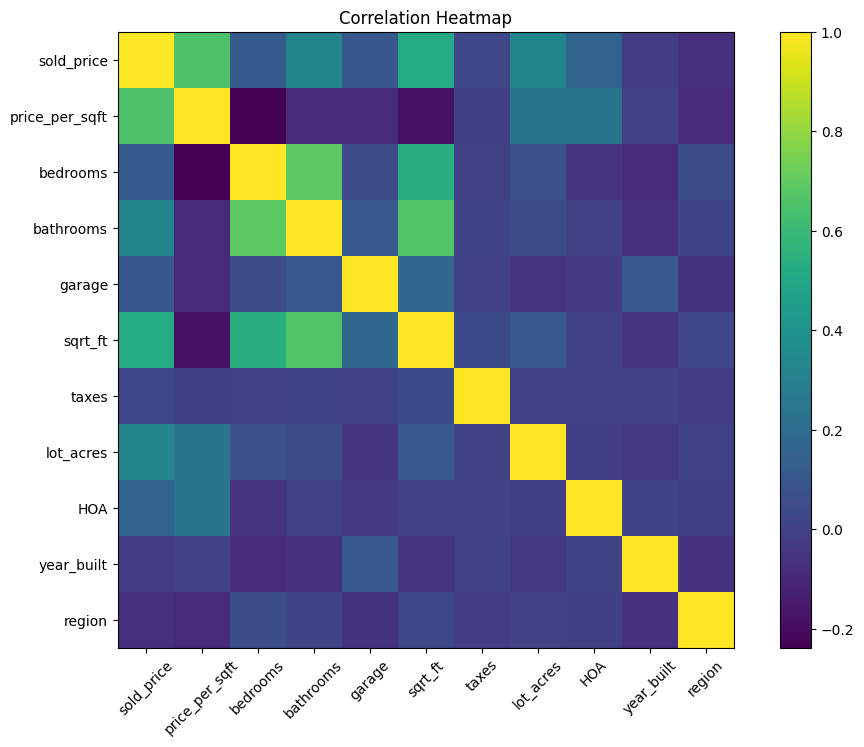

In [326]:
corr_matrix = df[[
    "sold_price", "price_per_sqft", "bedrooms", "bathrooms", "garage",
    "sqrt_ft", "taxes", "lot_acres", "HOA", "year_built", "region"
]].corr()

plt.figure(figsize=(12,8))
plt.imshow(corr_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Heatmap")
plt.show()


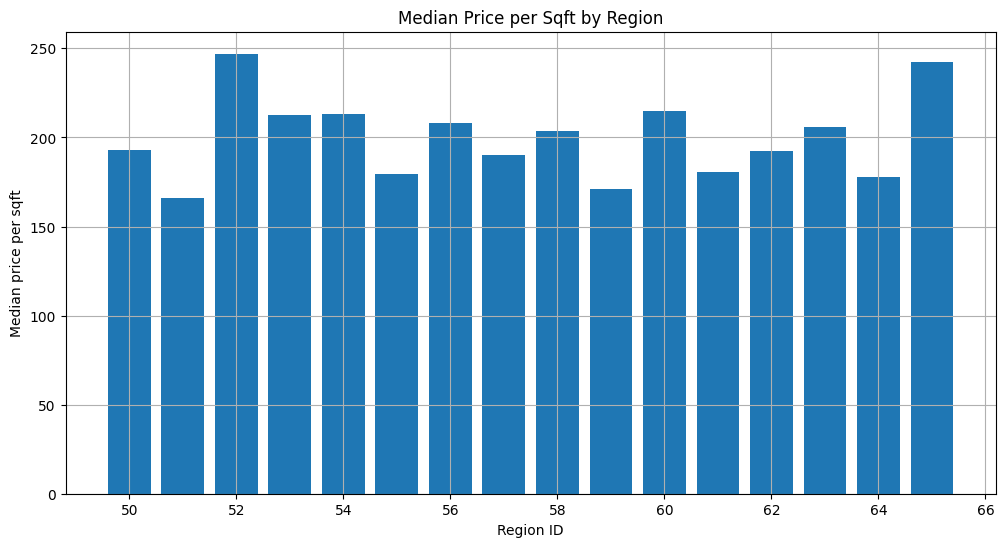

In [327]:
plt.figure(figsize=(12,6))
region_medians = df.groupby("region")["price_per_sqft"].median()

plt.bar(region_medians.index, region_medians.values)
plt.xlabel("Region ID")
plt.ylabel("Median price per sqft")
plt.title("Median Price per Sqft by Region")
plt.grid(True)
plt.show()


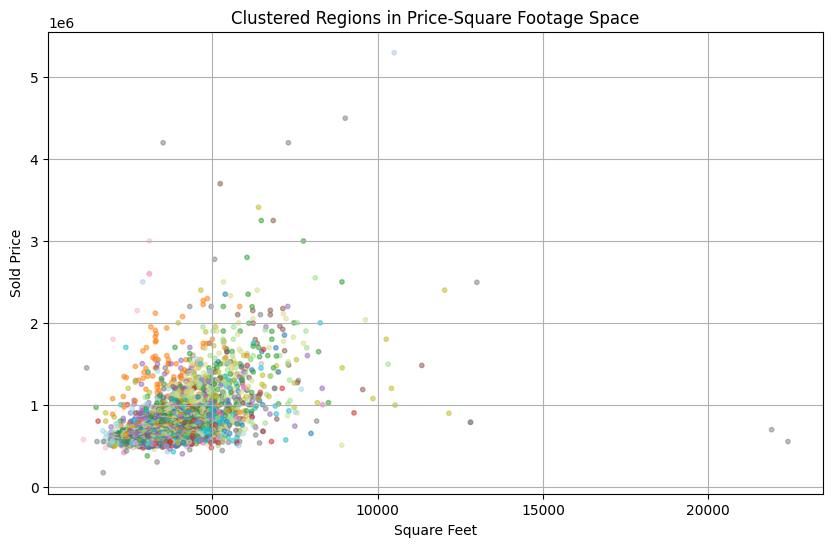

In [328]:
plt.figure(figsize=(10,6))
plt.scatter(df["sqrt_ft"], df["sold_price"],
            c=df["region"], cmap="tab20", alpha=0.5, s=10)
plt.xlabel("Square Feet")
plt.ylabel("Sold Price")
plt.title("Clustered Regions in Price-Square Footage Space")
plt.grid(True)
plt.show()


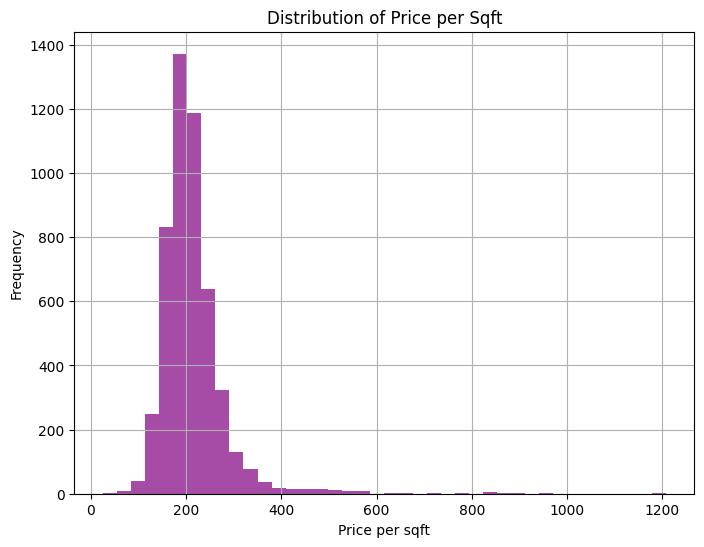

In [329]:
plt.figure(figsize=(8,6))
plt.hist(df["price_per_sqft"], bins=40, color="purple", alpha=0.7)
plt.xlabel("Price per sqft")
plt.ylabel("Frequency")
plt.title("Distribution of Price per Sqft")
plt.grid(True)
plt.show()


#Manual Prediction

In [330]:
def find_region(latitude, longitude, centers, shift=50):
    point = np.array([latitude, longitude], dtype=float)
    dists = np.sqrt(np.sum((centers - point)**2, axis=1))
    return np.argmin(dists) + shift




In [331]:
def predict_price_manual(
        rooms,
        garage,
        sqrt_ft,
        lot_acres,
        HOA,
        year_built,
        region,
        k=3
    ):

    x = np.array([
        rooms,
        garage,
        sqrt_ft,
        lot_acres,
        HOA,
        year_built,
        region
    ], dtype=float)

    x_norm = (x - X2_mean) / X2_std

    ppsqft = knn_regressor_predict(X2_train, y2_train, x_norm, k=k)
    price  = ppsqft * sqrt_ft
    return ppsqft, price




In [342]:
lat = 32.145
lon = -110.948

region_val = find_region(lat, lon, best_centers)
print("Region:", region_val)

ppsqft, price = predict_price_manual(
    rooms=4,
    garage=2,
    sqrt_ft=1200,
    lot_acres=.25,
    HOA=188,
    year_built=1899,
    region=region_val,
    k=3
)

print("Predicted price per sqft:", ppsqft)
print("Predicted sale price:", price)


Region: 57
Predicted price per sqft: 292.00462296871655
Predicted sale price: 350405.54756245983
